# Image Classification with Deep Learning Project #4

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***January, 2023***
* Instructor name: ***Abhineet Kulkarni***

### Overview:
- A radiology department in a medical center is interested in decreasing the work load of its radiologists by hiring a data scientist to develop a machine learning model to screen chest x-ray images and automatically mark those with pneumonia. 

- My goal is to build a Neural Network model to classify chest x-ray images as belonging to one of the two categoies: pneumonia and normal. My main purpose was to make predictions as accurately as possible while maximizing the number of True Positives (recall) and minimizing False Negatives, so that we catch as many people as possible with pneumonia (at the expense of marking some healthy people with pneumonia). 

### Data Understanding:
The data was obtained from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). 
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### Modeling:
1. The data was re-split into training, test and val sets using different ratios: 80% for train, 5% for validation and 15% for the test set.
2. The data was pre-processed, specifically the images were re-scaled and standardized. 
3. Several versions of neural networks were built, tuned and validated:

    - Baseline multilayer perceptron (MLP) - fully connected class of feedforward artificial neural network (ANN)
    - Deeper multilayer perceptron (MLP) 
    - Baseline Convolutional Neural Network - subtype of Neural Networks that is mainly used for applications in image and speech recognition.
    - Deeper Convolutional Neural Network
    - Tuned Convolutional Neural Network(s)

### Evaluation:
4. Accuracy was used as the scoring metric for tuning hyperparameters and recall was used for evaluating model performance. 

In [220]:
# Import required packages
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.ticker as mticker

from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras.preprocessing import image
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
      
import os

# Data Visualization

In [57]:
# specify the local directory of train, validation and test data:

train_dir = "Data/chest_xray/train/"
val_dir = "Data/chest_xray/val/"
test_dir ="Data/chest_xray/test/" 

### Display the first image with pneumonia from the train dataset:

Image name: person63_bacteria_306.jpeg
----------------------------
Image pixels:
[[210 208 206 ... 213 215 216]
 [210 208 206 ... 213 216 217]
 [210 208 205 ... 213 216 218]
 ...
 [ 16  15  14 ...  47  47  47]
 [ 16  15  14 ...  46  46  46]
 [ 16  15  14 ...  46  46  46]]
Image Shape: (736, 1048)
Max pixel: 255
Min pixel: 0


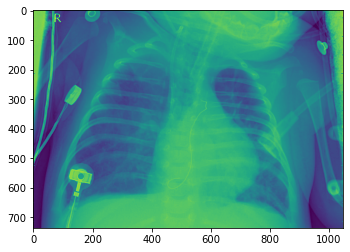

In [66]:
# List the images from the Data/chest_xray/train/PNEUMONIA directory:
pneumonia = os.listdir(train_dir+'/PNEUMONIA') 

# Combine the image directory with the specific jpeg to be able to locate it.
# Read the image into an array using imread():
sample_img = plt.imread(os.path.join(train_dir+'/PNEUMONIA', pneumonia[0]))

print(f"Image name: {pneumonia[0]}")
print("----------------------------")
print("Image pixels:")
print(sample_img)
print(f"Image Shape: {sample_img.shape}")  # width and height
print(f"Max pixel: {sample_img.max()}")
print(f"Min pixel: {sample_img.min()}")

# Display the image
plt.imshow(sample_img);

* The dimensions of the image are 1048 pixels width and 736 pixels height.
* One single color channel - not RGB.
* The maximum pixel value is 255 and the minimum is 0.

### Visualize the first 4 normal and 4 pneunomia x-rays:

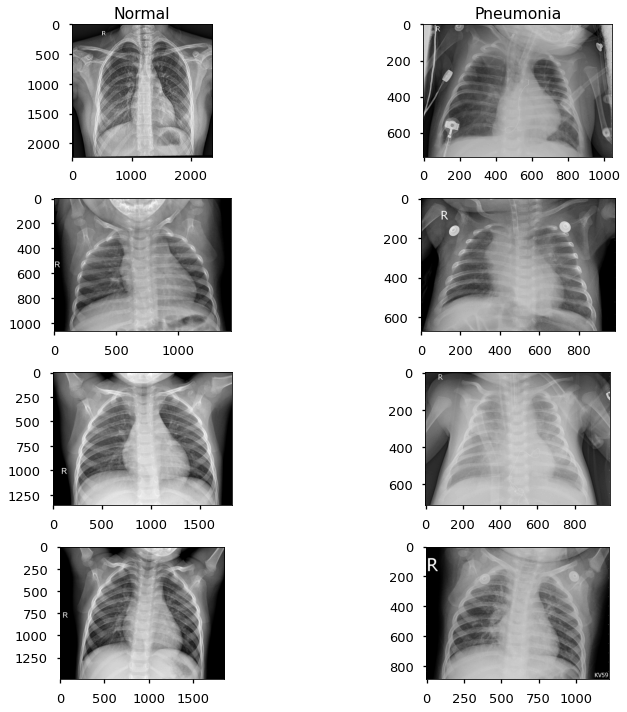

In [74]:
# Specify the set of images inside pnemonia and normal 
pneumonia = os.listdir("Data/chest_xray/train/PNEUMONIA")
normal = os.listdir("Data/chest_xray/train/NORMAL")

# Specify the location of the files = the directory
pneumonia_dir = "Data/chest_xray/train/PNEUMONIA"
normal_dir = "Data/chest_xray/train/NORMAL"

# Show the first four pictures from the train set of X-rays with and with/o Pneumonia 
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(4, 2, figsize=(12,10))  
    for i in range(4):
        # Combine the image directory with the specific jpeg to be able to locate it
        # Read the image into an array.
        img_pneumonia = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
        img_normal = plt.imread(os.path.join(normal_dir, normal[i]))
        # Display the image
        ax[i,1].imshow(img_pneumonia, cmap='gray')
        ax[i,0].imshow(img_normal, cmap='gray')
        
        ax[0,1].set_title("Pneumonia")
        ax[0,0].set_title("Normal")
        # plt.axis('off')
plt.tight_layout()

* The normal chest X-ray (left panel) seem to depict more clear lungs without any areas of abnormal opacification.
* The chest X-ray (right panel) with pneumonia seem to depict less clear lungs with some areas of opacification/consolidation.

### What is total number of normal and pneumonia images in the train-test-val sets?

Train Pneumomia: 3876
Train Normal: 1342
-------------------
Test Pneumomia: 390
Test Normal: 234
--------------------
Val Pneumomia: 9
Val Normal: 9
--------------------
Train Images Percentage: 0.89
Test Images Percentage: 0.106
Val Images Percentage: 0.003


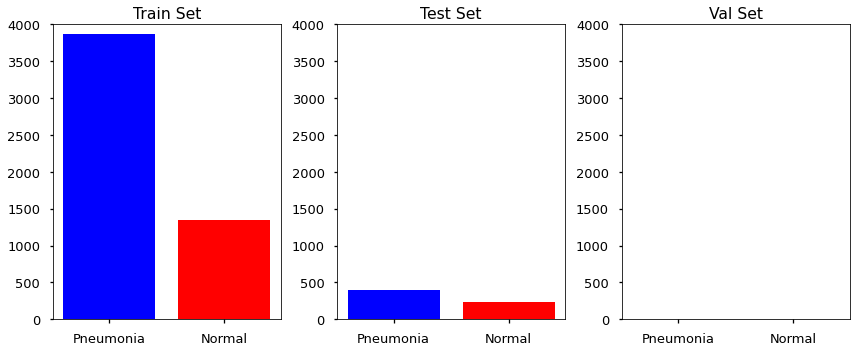

In [82]:
# Specify the set of images inside pnemonia and normal for train, test, val sets:
num_pneumonia_train = (len(os.listdir("Data/chest_xray/train/PNEUMONIA")) ) 
num_normal_train = (len(os.listdir("Data/chest_xray/train/NORMAL")) )
                       
num_pneumonia_test = (len(os.listdir("Data/chest_xray/test/PNEUMONIA")) )
num_normal_test = (len(os.listdir("Data/chest_xray/test/NORMAL")) )
      
num_pneumonia_val = (len(os.listdir("Data/chest_xray/val/PNEUMONIA")) )
num_normal_val = (len(os.listdir("Data/chest_xray/val/NORMAL")))
                             
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_train, num_normal_train], color=["blue", "red"])
    ax1.set_title('Train Set')
    ax2.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_test, num_normal_test], color=["blue", "red"])
    ax2.set_title('Test Set')
    ax3.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_val, num_normal_val], color=["blue", "red"]) 
    ax3.set_title('Val Set')
    
    ax1.set_ylim([0, 4000])
    ax2.set_ylim([0, 4000])
    ax3.set_ylim([0, 4000])
    plt.tight_layout()
    
print(f"Train Pneumomia: {num_pneumonia_train}")
print(f"Train Normal: {num_normal_train}")
print("-------------------")
print(f"Test Pneumomia: {num_pneumonia_test}")
print(f"Test Normal: {num_normal_test}")
print("--------------------")
print(f"Val Pneumomia: {num_pneumonia_val}")
print(f"Val Normal: {num_normal_val}")
print("--------------------")
          
TrainTotal = num_pneumonia_train + num_normal_train
TestTotal = num_pneumonia_test + num_normal_test
ValTotal = num_pneumonia_val + num_normal_val
Total = TrainTotal + TestTotal + ValTotal
print(f"Train Images Percentage: {np.round((TrainTotal / Total),3) }")
print(f"Test Images Percentage: {np.round((TestTotal / Total),3) }")
print(f"Val Images Percentage: {np.round((ValTotal / Total),3) }")


* Number of images in the **validation** set appears too low with a total of 18 images and total percentage of **.3%**. We need to boost it to at about 10%. 
* Number of images in the **test** set appears ideal with a total percentage of **10%**. 
* Number of images in the **train** set is good with a total percentage of **89%**, but we will move some of the images from train to the validation set to boost the numbers in the val set. 80% is sufficient for the train set.  

### Change the size of the Train-Test-Val sets:
* Using splitfolders package (https://pypi.org/project/split-folders/)
* Split the data in the folder **"Data/INPUT"** with **"Pneumonia" and "Normal"** subfolders into the output folder **"Data/OUTPUT"** with **"train","test","val"** subfolders using the pre-specified percentages.

In [8]:
# !pip install split-folders
import splitfolders

# Change the size of Train, Test and Val sets with ratios: .81, .09, .1. 
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("Data/INPUT", output="Data/OUTPUT",
    seed=1337, ratio=(.81, .09, .1), group_prefix=None, move=False) # default values

Copying files: 5856 files [00:08, 654.41 files/s]


### What is total number of normal and pneumonia images in the NEW train-test-val sets?

Train Pneumomia: 3461
Train Normal: 1282
-------------------
Test Pneumomia: 428
Test Normal: 159
--------------------
Val Pneumomia: 384
Val Normal: 142
--------------------
Train Images Percentage: 0.81
Test Images Percentage: 0.1
Val Images Percentage: 0.09


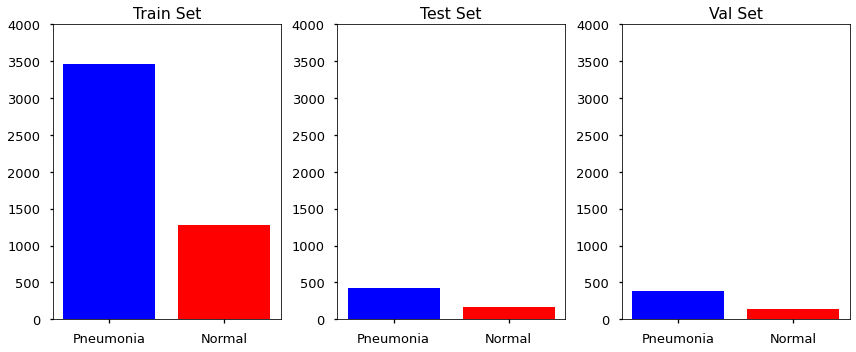

In [86]:
num_pneumonia_train = (len(os.listdir("Data/OUTPUT/train/PNEUMONIA")) ) 
num_normal_train = (len(os.listdir("Data/OUTPUT/train/NORMAL")) )
                       
num_pneumonia_test = (len(os.listdir("Data/OUTPUT/test/PNEUMONIA")) )
num_normal_test = (len(os.listdir("Data/OUTPUT/test/NORMAL")) )
      
num_pneumonia_val = (len(os.listdir("Data/OUTPUT/val/PNEUMONIA")) )
num_normal_val = (len(os.listdir("Data/OUTPUT/val/NORMAL")))
                             
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_train, num_normal_train], color=["blue", "red"])
    ax1.set_title('Train Set')
    ax2.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_test, num_normal_test], color=["blue", "red"])
    ax2.set_title('Test Set')
    ax3.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_val, num_normal_val], color=["blue", "red"]) 
    ax3.set_title('Val Set')
    
    ax1.set_ylim([0, 4000])
    ax2.set_ylim([0, 4000])
    ax3.set_ylim([0, 4000])
    plt.tight_layout()
    
print(f"Train Pneumomia: {num_pneumonia_train}")
print(f"Train Normal: {num_normal_train}")
print("-------------------")
print(f"Test Pneumomia: {num_pneumonia_test}")
print(f"Test Normal: {num_normal_test}")
print("--------------------")
print(f"Val Pneumomia: {num_pneumonia_val}")
print(f"Val Normal: {num_normal_val}")
print("--------------------")
          
TrainTotal = num_pneumonia_train + num_normal_train
TestTotal = num_pneumonia_test + num_normal_test
ValTotal = num_pneumonia_val + num_normal_val
Total = TrainTotal + TestTotal + ValTotal
print(f"Train Images Percentage: {np.round((TrainTotal / Total),3) }")
print(f"Test Images Percentage: {np.round((TestTotal / Total),3) }")
print(f"Val Images Percentage: {np.round((ValTotal / Total),3) }")   

* New split looks much better with about 80% train, 10% test and 10% validation. 

In [269]:
# Specify the new location of the train, test and val images 
train_dir = "Data/OUTPUT/train/"
test_dir ="Data/OUTPUT/test/" 
val_dir = "Data/OUTPUT/val/"

# Image Preprocessing:

## Data Normalization:

* **Pixel Normalization**: For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. 

* **Size Rescaling**: Since all of the images are different sizes, we need to rescale (standardize) them using a target width and height. We will use a size of 128x128. In general, the resolutions for training CNNs usually range between 64 × 64 and 256 × 256.

* **Reshaping into tensors**: Convolutional Neural Networks takes its input as **tensors**. We will use the output from flow_from_directory() directly to feed them into the CNNs. 

* **Reshaping into vectors**: A multilayer perceptron (MLP) - fully connected atrificial Neural Network (ANN) takes its input as **vectors** (single-dimensional array), not matrices (2-D grid) or tensors (generalized matrix). So we need to reshape the images into a single 16384-dimensional vector (128x128) to feed them into the ANNs. 

In [166]:
print(f"Train Images Total#: {TrainTotal}")
print(f"Test Images Total#: {TestTotal}")
print(f"Val Images Total#: {ValTotal}")

Train Images Total#: 4743
Test Images Total#: 587
Val Images Total#: 526


### Format the data using Keras ImageDataGenerator():
* Rescale pixel values to be between 0-1.
* Rescale the size to be 128 x 128
* Keep the one dimension since the images are greyscale # color_mode= "grayscale"
* Reformat the target data into 1s (pneumonia) and 0s (normal) # class_mode='binary'


In [270]:
# For example, if you have 1000 images in your dataset and the batch size is defined as 10. 
# Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.
# We will use the size of the whole dataset since there are no computational issues with ~5000 images. 

# Each pixel is originally between 255 and 0, Rescale the data to be between 0 and 1. 
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

# Target Size: 128 x 128: The dimensions to which all images found will be resized:

# get the data from the training directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128, 128, 3),
                                                    batch_size=4743, # default is 32
                                                    class_mode='binary',
                                                    color_mode= "grayscale")

# get the data from the validation directory
test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(128, 128, 3),
                                                batch_size=587,
                                                class_mode='binary',
                                                color_mode= "grayscale")

# get the data from the validation directory
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(128, 128, 3),
                                                batch_size=526,
                                                class_mode='binary',
                                                color_mode= "grayscale")

print(train_generator.class_indices)

Found 4743 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 526 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


4743 divisors: 17, 31, 51, 93, 153,

In [271]:
train_generator.image_shape, test_generator.image_shape, val_generator.image_shape

((128, 128, 3, 1), (128, 128, 3, 1), (128, 128, 3, 1))

### Create the transformed data sets:

In [94]:
# next() returns the next item in the iterator = The first batch of the images, in our case all images. 
train_image, train_label = next(train_generator)
test_image, test_label = next(test_generator)
val_image, val_label = next(val_generator)

In [95]:
print(train_image.shape)
print(train_label.shape)

(4743, 128, 128, 1)
(4743,)


### Reshape the transformed data into vectors:

In [96]:
# Reshape images:

X_train = train_image.reshape(train_image.shape[0], -1)
X_test = test_image.reshape(test_image.shape[0], -1)
X_val = val_image.reshape(val_image.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4743, 16384)
(587, 16384)
(526, 16384)


In [97]:
# Reshape labels:

y_train = np.reshape(train_label, (4743,1))   # y_train2 = train_label.reshape(train_label.shape[0], 1)
y_test = np.reshape(test_label, (587,1))
y_val = np.reshape(val_label, (526,1))

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4743, 1)
(587, 1)
(526, 1)


### Visualize some of the transformed images from the training dataset:
* The images appear in a standardized way now:

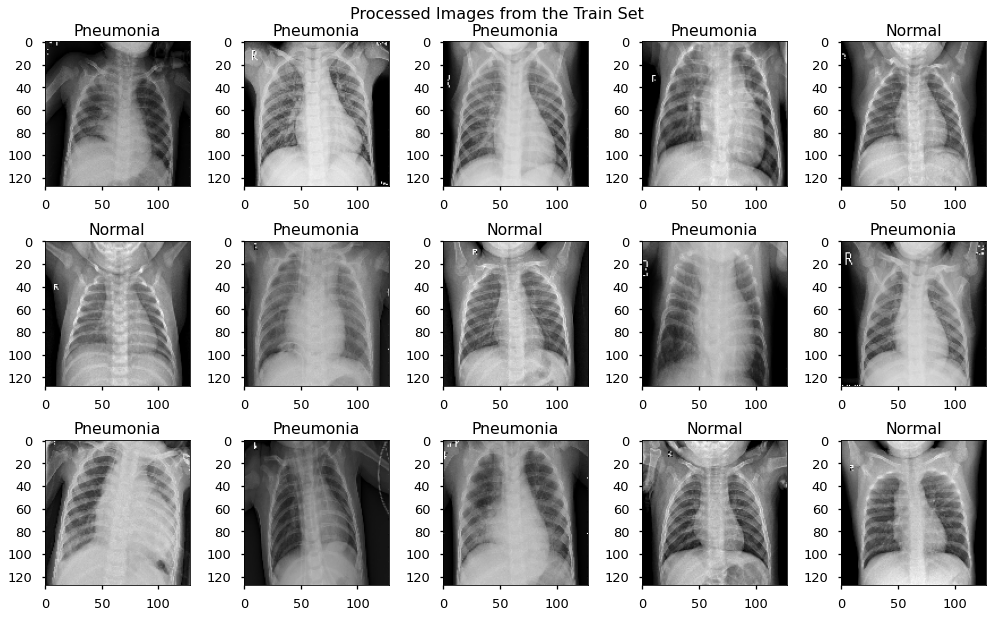

In [98]:
plt.figure(figsize=(14,14))

with plt.style.context('seaborn-talk'):
    for i in range(15):
        ax = plt.subplot(5,5,i+1) # This is object oriented and different from plt.subplots() 
        plt.imshow(train_image[i], cmap='gray')
        if train_label[i]==0:
            plt.title("Normal")
        else:
            plt.title("Pneumonia")

plt.suptitle('Processed Images from the Train Set',fontsize=16)
plt.tight_layout()
plt.show()

# MODELING:

## Baseline Artificial Neural Network (multilayer perceptron MLP)
* One input layer with 5 neurons wiht relu activation which works well with images. 
* One output layer with 1 neuron for the binary classification (normal versus pneumonia). 
* Input shape is a vector with 16384 rows (128 x 128)
* Using Adam optimizer ("Adaptive Moment Estimation") an adoptive learning rate optimizer which is widely used for training deep neural networks and in image processing. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm. Learning rate defaults to 0.001 but the contribution of gradients to updated weight varies over epochs, hence ADAPTIVE. 

In [167]:
# specify the model:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(5, activation='relu', input_shape = (16384,))) 
# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))  # because this is a binary decision task

model.compile(loss = 'binary_crossentropy',  # because this is a binary decision task
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [168]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 5)                 81925     
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 6         
Total params: 81,931
Trainable params: 81,931
Non-trainable params: 0
_________________________________________________________________


In [169]:
# Fit model, set epochs to 31 because 4743 is divisible to 31. 
BaselineNN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose =0, 
                    validation_data = (X_val, y_val))

### Evaluate the model performance: 
* A traditional Neural Network and CNN uses different data shapes as the input images. Vector for ANN and tensor for CNN. 
* A traditional Neural Network and CNN also differ in how how accuracy metrics are reported: "accuracy" and "val_accuracy" for ANN versus "acc" and "val_acc" for CNN. 
* Therefore, we need to specify the result from the model, Xtrain, Xtest, accuracy and valaccuracy for the function below to be generalizable:

In [203]:
def visualize_model_performance(result, Xtrainname, Xtestname, accuracy, valaccuracy):
    
    with plt.style.context('seaborn-talk'):
        
        # Diplay train and validation loss and accuracy:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
        ax1.plot(result.history['loss'])
        ax1.plot(result.history['val_loss'])
        ax1.set_title("Loss")
        ax1.legend(labels = ['train loss', 'val loss'])
        ax2.plot(result.history[accuracy])
        ax2.plot(result.history[valaccuracy])
        ax2.legend(labels = ['train acc', 'val acc'])
        ax2.set_title('Accuracy')

        # Output (probability) predictions for the test set 
        y_hat_test = result.model.predict(Xtestname)
        y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
        y_true = y_test.astype(np.int)
    
        # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax3)
        ax3.set_title('Confusion Matrix - TestSet')

        # Print Classification Report displaying the performance of the model on the test set using various metrics:
        print('Classification Report:')
        print(classification_report(y_true, y_pred))
        print('\n')

        # Print final train and test loss and accuracy:
        train_loss, train_acc = result.model.evaluate(Xtrainname, y_train);
        test_loss, test_acc = result.model.evaluate(Xtestname, y_test);
        print('--------------------------')
        print(f'Final Train Loss: {np.round(train_loss,4)}')
        print(f'Final Test Loss: {np.round(test_loss,4)}') 
        print('--------------------------')
        print(f'Final Train Acc: {np.round(train_acc,4)}')
        print(f'Final Test Acc: {np.round(test_acc,4)}') 
        print('\n')
        

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       159
           1       0.96      0.95      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.93      0.92       587
weighted avg       0.94      0.94      0.94       587



19/19 [==============================] - 0s 1ms/step - loss: 0.2076 - accuracy: 0.9370
--------------------------
Final Train Loss: 0.0375
Final Test Loss: 0.2076
--------------------------
Final Train Acc: 0.9911
Final Test Acc: 0.937




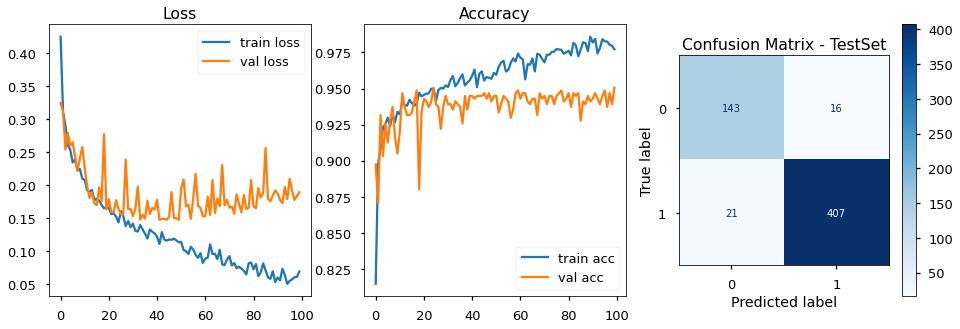

In [204]:
visualize_model_performance(BaselineNN, X_train, X_test, "accuracy", "val_accuracy")

##  Bigger/Deeper Neural Network:
* Add an input layer with 64 meurons
* Add two hidden layers with 32 and 10 neurons. 
* Add the output layer with 1 neuron. 

In [172]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(64, activation='relu', input_shape = (16384,)))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [173]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 64)                1048640   
_________________________________________________________________
dense_72 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_73 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 11        
Total params: 1,051,061
Trainable params: 1,051,061
Non-trainable params: 0
_________________________________________________________________


In [174]:
# Fit model set epochs to ensure convergence
BiggerNN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose = 0,
                    validation_data = (X_val, y_val))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       159
           1       0.97      0.93      0.95       428

    accuracy                           0.93       587
   macro avg       0.90      0.93      0.91       587
weighted avg       0.93      0.93      0.93       587



19/19 [==============================] - 0s 1ms/step - loss: 0.3282 - accuracy: 0.9302
--------------------------
Final Train Loss: 0.0276
Final Test Loss: 0.3282
--------------------------
Final Train Acc: 0.9947
Final Test Acc: 0.9302




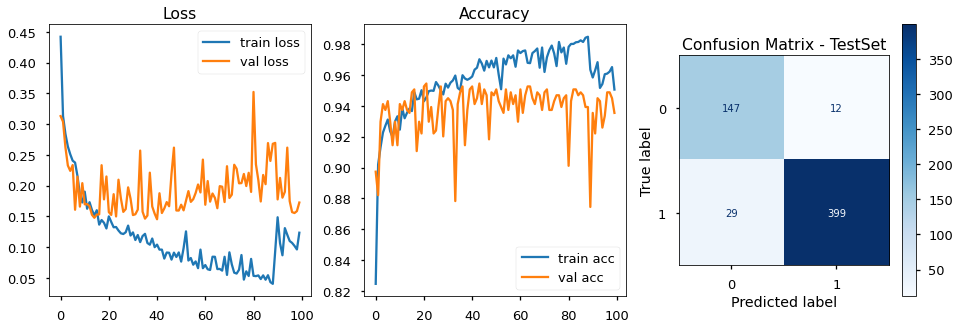

In [205]:
visualize_model_performance(BiggerNN, X_train, X_test, "accuracy", "val_accuracy")

#  Neural Network with Class Weights (due to class inbalance):
* Using the same number of layers / neurons as above but adding class weights to see if it would improve performance. 

In [176]:
pneumonia = os.listdir("Data/OUTPUT/train/PNEUMONIA")
normal = os.listdir("Data/OUTPUT/train/NORMAL")

weight_pneumonia = len(normal)/(len(normal) + len(pneumonia))
weight_normal = len(pneumonia)/(len(normal) + len(pneumonia)) 

print(len(pneumonia), len(normal))
print(f'Weight for class pneumonia: {np.round(weight_pneumonia, 2)}')
print(f'Weight for class normal: {np.round(weight_normal, 2)}')
    

3461 1282
Weight for class pneumonia: 0.27
Weight for class normal: 0.73


In [177]:
weights_dict = {0:np.round(weight_normal, 2) , 1: np.round(weight_pneumonia, 2)}
weights_dict

{0: 0.73, 1: 0.27}

In [179]:
weightedNN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose = 0, 
                    validation_data = (X_val, y_val), class_weight = weights_dict)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       159
           1       0.97      0.93      0.95       428

    accuracy                           0.93       587
   macro avg       0.90      0.93      0.91       587
weighted avg       0.93      0.93      0.93       587



19/19 [==============================] - 0s 1ms/step - loss: 0.3282 - accuracy: 0.9302
--------------------------
Final Train Loss: 0.0276
Final Test Loss: 0.3282
--------------------------
Final Train Acc: 0.9947
Final Test Acc: 0.9302




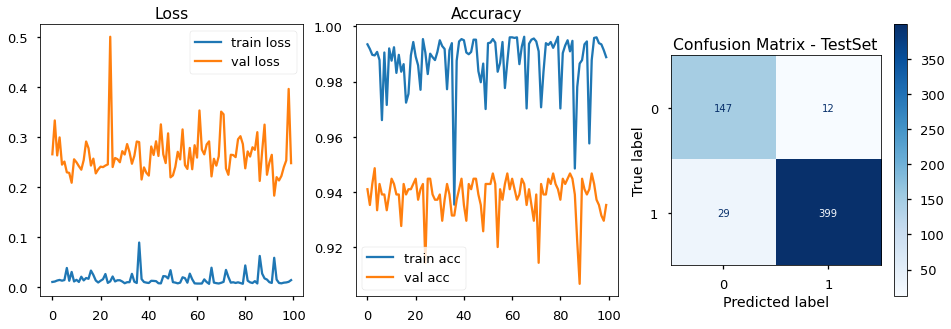

In [206]:
visualize_model_performance(weightedNN, X_train, X_test, "accuracy", "val_accuracy")

## Baseline Convolutional Neural Network:
* Baseline model with 2 convolutional layers, 2 max pooling layers, and one fully connected layer
* Convolutional layer performs a dot product between the kernel and a portion of the receptive field. 
* The pooling layer replaces the output of the network by deriving a summary statistic: max pooling reports the maximum output from the neighborhood.
* Number of output filters in the convolutional layers are 16 and 32. Layers early in the network architecture (i.e., closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.
* Kernel Size is 3 x 3. If your images are smaller than 128×128 you may want to consider sticking with strictly 1×1 and 3×3 filters.
* Fully connected layer: Neurons in this layer have full connectivity with all neurons in the preceding and succeeding layer as seen in regular FCNN. The FC layer helps to map the representation between the input and the output.

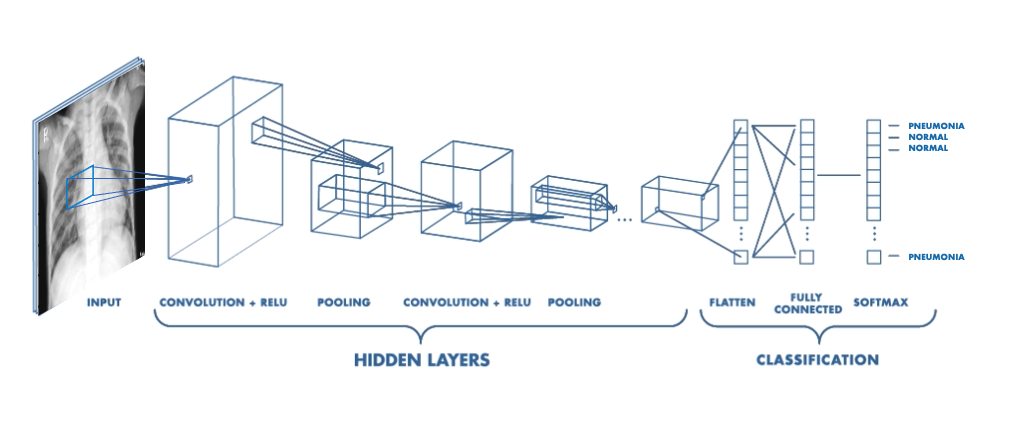

In [181]:
model = Sequential()

# 1st Convolution and Pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3))) 
model.add(MaxPool2D(pool_size = (2, 2)))  

# 2nd Convolution and Pooling
model.add(Conv2D(32, (3, 3), activation='relu')) 
model.add(MaxPool2D(pool_size = (2, 2))) 

# Flatten
model.add(Flatten())

# Include a fully-connected layer and an output layer
model.add(Dense(activation = 'relu', units = 32)) # inner layer
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 126, 126, 16)      160       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 32)                921632    
_________________________________________________________________
dense_76 (Dense)             (None, 1)               

**Early Stopping:** Specify early stopping training  for all the subsequent models so that once the model performance stops improving on a hold out validation dataset. the trainign stops. It helpos with overfitting and running for more epochs unnecessarily: 

In [215]:
# Patience number of 10: the number of epochs to wait before early stop if no progress on the validation set. 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [183]:
# Train the model
BaselineCNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data = (val_image, y_val), callbacks = [early_stop])  

Epoch 1/100
153/153 [==============================] - 16s 105ms/step - loss: 0.2836 - acc: 0.8830 - val_loss: 0.1750 - val_acc: 0.9202
Epoch 2/100
153/153 [==============================] - 16s 105ms/step - loss: 0.1526 - acc: 0.9401 - val_loss: 0.1806 - val_acc: 0.9259
Epoch 3/100
153/153 [==============================] - 16s 104ms/step - loss: 0.1449 - acc: 0.9477 - val_loss: 0.1477 - val_acc: 0.9449
Epoch 4/100
153/153 [==============================] - 16s 104ms/step - loss: 0.1170 - acc: 0.9578 - val_loss: 0.1276 - val_acc: 0.9506
Epoch 5/100
153/153 [==============================] - 16s 105ms/step - loss: 0.1074 - acc: 0.9589 - val_loss: 0.1384 - val_acc: 0.9449
Epoch 6/100
153/153 [==============================] - 16s 104ms/step - loss: 0.0985 - acc: 0.9663 - val_loss: 0.1589 - val_acc: 0.9468
Epoch 7/100
153/153 [==============================] - 17s 109ms/step - loss: 0.0897 - acc: 0.9661 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       159
           1       0.98      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.95      0.94       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 0s 19ms/step - loss: 0.1182 - acc: 0.9557
--------------------------
Final Train Loss: 0.0706
Final Test Loss: 0.1182
--------------------------
Final Train Acc: 0.9753
Final Test Acc: 0.9557




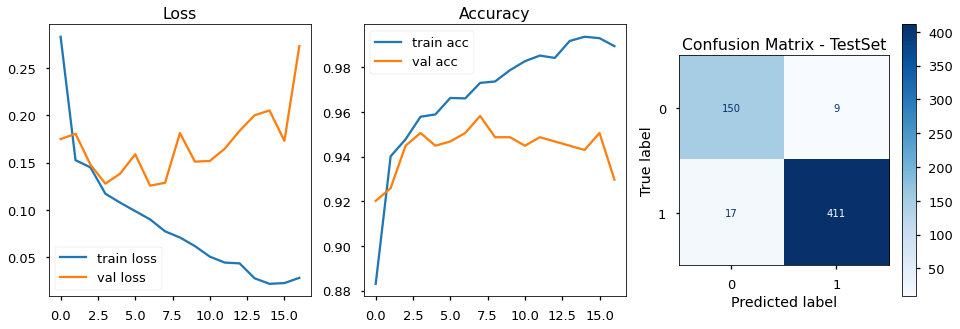

In [207]:
visualize_model_performance(BaselineCNN, train_image, test_image, "acc", "val_acc")

## Deeper CNN with more layers, filters and neurons:

In [185]:
model = Sequential()

# 1st Convolution and Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))  # 32 is number of filters

# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

# Flatten
model.add(Flatten())

# activation
model.add(Dense(activation = 'relu', units = 128)) # inner layer
model.add(Dense(activation = 'relu', units = 64)) # inner layer
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 25088)           

In [186]:
BiggerCNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data = (val_image, y_val), callbacks = [early_stop])  

Epoch 1/100
153/153 [==============================] - 42s 273ms/step - loss: 0.2963 - acc: 0.8779 - val_loss: 0.1710 - val_acc: 0.9411
Epoch 2/100
153/153 [==============================] - 41s 269ms/step - loss: 0.1679 - acc: 0.9363 - val_loss: 0.1761 - val_acc: 0.9240
Epoch 3/100
153/153 [==============================] - 41s 269ms/step - loss: 0.1326 - acc: 0.9492 - val_loss: 0.1322 - val_acc: 0.9506
Epoch 4/100
153/153 [==============================] - 41s 268ms/step - loss: 0.1143 - acc: 0.9555 - val_loss: 0.1663 - val_acc: 0.9449
Epoch 5/100
153/153 [==============================] - 41s 268ms/step - loss: 0.0991 - acc: 0.9627 - val_loss: 0.1366 - val_acc: 0.9487
Epoch 6/100
153/153 [==============================] - 41s 268ms/step - loss: 0.0883 - acc: 0.9680 - val_loss: 0.1310 - val_acc: 0.9525
Epoch 7/100
153/153 [==============================] - 41s 268ms/step - loss: 0.0788 - acc: 0.9701 - val_loss: 0.1609 - val_acc: 0.9411
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       159
           1       0.99      0.95      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 1s 59ms/step - loss: 0.1157 - acc: 0.9574
--------------------------
Final Train Loss: 0.043
Final Test Loss: 0.1157
--------------------------
Final Train Acc: 0.9863
Final Test Acc: 0.9574




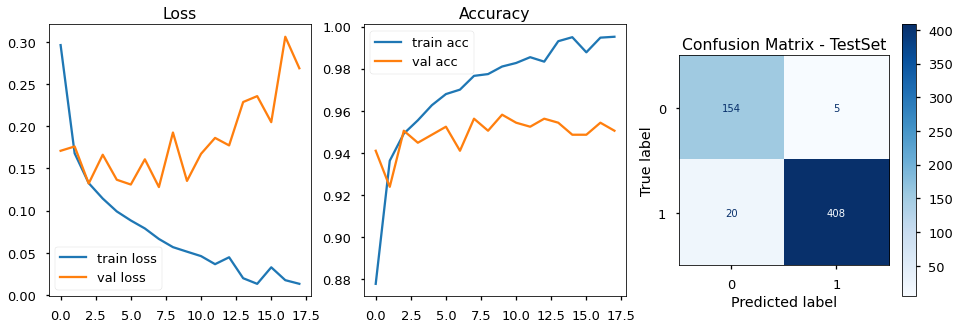

In [208]:
visualize_model_performance(BiggerCNN, train_image, test_image, "acc", "val_acc")

# CNN with dropout regularization:
* Dropout regularization helps prevent neural networks from overfitting. Dropout works by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

In [252]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization, turn off 40% of the neurons

# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# Flatten
model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128)) # inner layer
model.add(layers.Dropout(0.2)) # regularization
model.add(Dense(activation = 'relu', units = 64)) # inner layer
model.add(layers.Dropout(0.2)) # regularization
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 128)     

In [253]:
Dropout_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), callbacks = [early_stop] )

Epoch 1/100


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_33 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape [31, 128, 128, 1]


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       159
           1       0.99      0.94      0.97       428

    accuracy                           0.95       587
   macro avg       0.93      0.96      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 59ms/step - loss: 0.1134 - acc: 0.9506
--------------------------
Final Train Loss: 0.0635
Final Test Loss: 0.1134
--------------------------
Final Train Acc: 0.9762
Final Test Acc: 0.9506




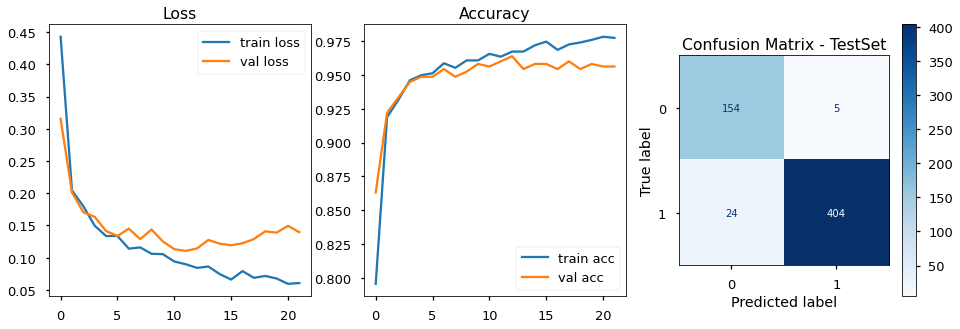

In [209]:
visualize_model_performance(Dropout_CNN, train_image, test_image, "acc", "val_acc")

# CNN with dropout and class weights:

In [191]:
Weighted_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop], class_weight = weights_dict)

Epoch 1/100
153/153 [==============================] - 47s 304ms/step - loss: 0.0347 - acc: 0.9701 - val_loss: 0.1375 - val_acc: 0.9525
Epoch 2/100
153/153 [==============================] - 47s 310ms/step - loss: 0.0320 - acc: 0.9703 - val_loss: 0.1291 - val_acc: 0.9525
Epoch 3/100
153/153 [==============================] - 47s 308ms/step - loss: 0.0331 - acc: 0.9680 - val_loss: 0.1134 - val_acc: 0.9601
Epoch 4/100
153/153 [==============================] - 47s 310ms/step - loss: 0.0291 - acc: 0.9720 - val_loss: 0.1245 - val_acc: 0.9582
Epoch 5/100
153/153 [==============================] - 47s 310ms/step - loss: 0.0297 - acc: 0.9713 - val_loss: 0.1361 - val_acc: 0.9601
Epoch 6/100
153/153 [==============================] - 47s 309ms/step - loss: 0.0304 - acc: 0.9732 - val_loss: 0.1252 - val_acc: 0.9544
Epoch 7/100
153/153 [==============================] - 48s 311ms/step - loss: 0.0288 - acc: 0.9715 - val_loss: 0.1825 - val_acc: 0.9430
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       159
           1       0.99      0.94      0.97       428

    accuracy                           0.95       587
   macro avg       0.93      0.96      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 58ms/step - loss: 0.1134 - acc: 0.9506
--------------------------
Final Train Loss: 0.0635
Final Test Loss: 0.1134
--------------------------
Final Train Acc: 0.9762
Final Test Acc: 0.9506




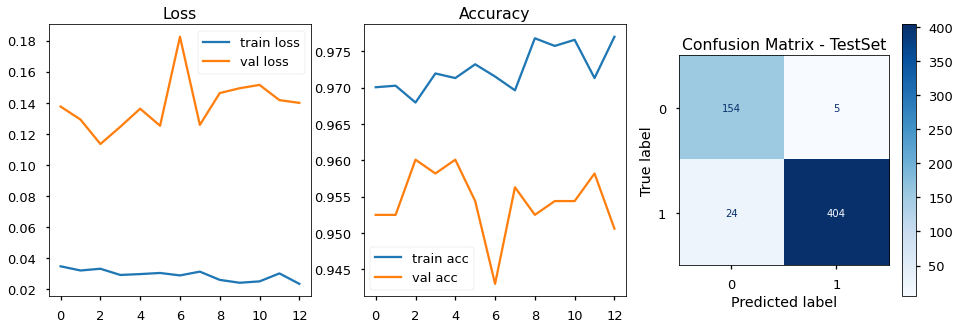

In [210]:
visualize_model_performance(Weighted_CNN, train_image, test_image, "acc", "val_acc")

## CNN with batch regularization:

* Batch normalization is a technique to standardize the inputs to a network, applied to either the activations of a prior layer or inputs directly.
* Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

In [193]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization


# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# Flatten
model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128)) # inner layer
model.add(BatchNormalization())
model.add(layers.Dropout(0.2)) # regularization

model.add(Dense(activation = 'relu', units = 64)) # inner layer
model.add(BatchNormalization())
model.add(layers.Dropout(0.2)) # regularization

model.add(Dense(activation = 'sigmoid', units = 1)) # output layer


# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_33 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_34 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 30, 64)      

In [194]:
BatchNorm_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 67s 438ms/step - loss: 0.2535 - acc: 0.9104 - val_loss: 1.6161 - val_acc: 0.2700
Epoch 2/100
153/153 [==============================] - 67s 437ms/step - loss: 0.1691 - acc: 0.9429 - val_loss: 0.7258 - val_acc: 0.7319
Epoch 3/100
153/153 [==============================] - 67s 437ms/step - loss: 0.1413 - acc: 0.9505 - val_loss: 0.5060 - val_acc: 0.8669
Epoch 4/100
153/153 [==============================] - 67s 438ms/step - loss: 0.1358 - acc: 0.9534 - val_loss: 1.0819 - val_acc: 0.7091
Epoch 5/100
153/153 [==============================] - 66s 433ms/step - loss: 0.1086 - acc: 0.9606 - val_loss: 0.6693 - val_acc: 0.9011
Epoch 6/100
153/153 [==============================] - 67s 437ms/step - loss: 0.1063 - acc: 0.9627 - val_loss: 1.0589 - val_acc: 0.7548
Epoch 7/100
153/153 [==============================] - 66s 435ms/step - loss: 0.0961 - acc: 0.9661 - val_loss: 0.2223 - val_acc: 0.9144
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       159
           1       0.97      0.97      0.97       428

    accuracy                           0.96       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 2s 89ms/step - loss: 0.1193 - acc: 0.9591
--------------------------
Final Train Loss: 0.0139
Final Test Loss: 0.1193
--------------------------
Final Train Acc: 0.997
Final Test Acc: 0.9591




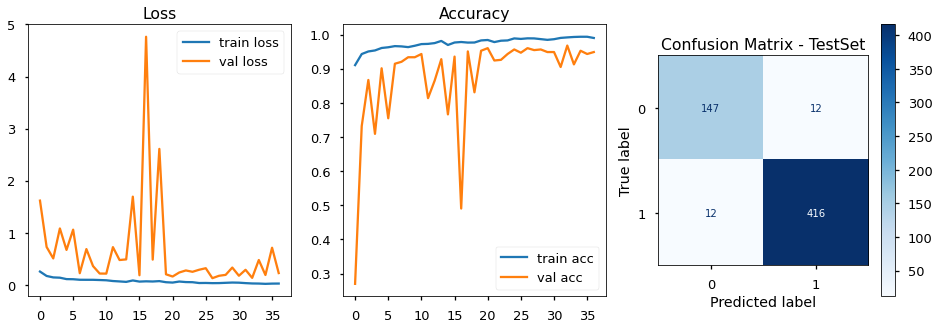

In [211]:
visualize_model_performance(BatchNorm_CNN, train_image, test_image, "acc", "val_acc")

## CNN with L2 regularization:
* L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).
* L2 regularization combats overfitting by forcing weights to be small.

In [216]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization


# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.4)) # regularization

# Flatten
model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(layers.Dropout(0.2)) # regularization

model.add(Dense(activation = 'relu', units = 64, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(layers.Dropout(0.2)) # regularization

model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 28, 28, 128)     

In [197]:
L2_Regularization_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 48s 313ms/step - loss: 1.0230 - acc: 0.8003 - val_loss: 0.5143 - val_acc: 0.9106
Epoch 2/100
153/153 [==============================] - 48s 314ms/step - loss: 0.4581 - acc: 0.8876 - val_loss: 0.4141 - val_acc: 0.9087
Epoch 3/100
153/153 [==============================] - 48s 311ms/step - loss: 0.3821 - acc: 0.9026 - val_loss: 0.3276 - val_acc: 0.9316
Epoch 4/100
153/153 [==============================] - 48s 311ms/step - loss: 0.3592 - acc: 0.9060 - val_loss: 0.3554 - val_acc: 0.9221
Epoch 5/100
153/153 [==============================] - 48s 312ms/step - loss: 0.3260 - acc: 0.9155 - val_loss: 0.2926 - val_acc: 0.9449
Epoch 6/100
153/153 [==============================] - 48s 311ms/step - loss: 0.3314 - acc: 0.9098 - val_loss: 0.2839 - val_acc: 0.9373
Epoch 7/100
153/153 [==============================] - 48s 313ms/step - loss: 0.3201 - acc: 0.9195 - val_loss: 0.2774 - val_acc: 0.9449
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       159
           1       0.97      0.96      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 59ms/step - loss: 0.1927 - acc: 0.9506
--------------------------
Final Train Loss: 0.1675
Final Test Loss: 0.1927
--------------------------
Final Train Acc: 0.9665
Final Test Acc: 0.9506




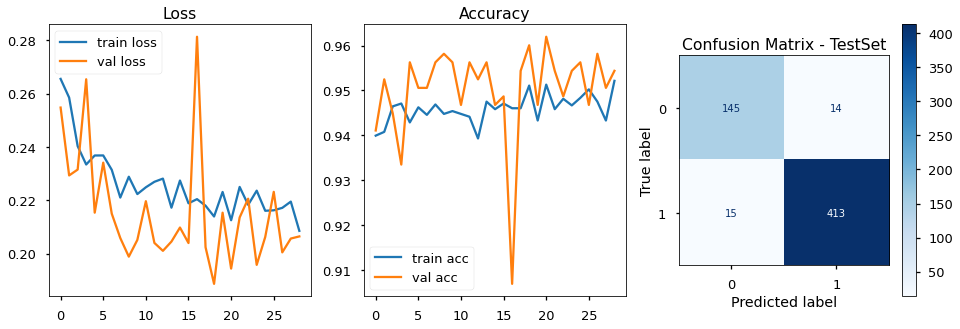

In [213]:
visualize_model_performance(L2_Regularization_CNN, train_image, test_image, "acc", "val_acc")

## CNN with increase batch size:

In [199]:
Increased_Batch_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=93,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
51/51 [==============================] - 44s 862ms/step - loss: 0.2103 - acc: 0.9509 - val_loss: 0.1933 - val_acc: 0.9563
Epoch 2/100
51/51 [==============================] - 44s 860ms/step - loss: 0.2112 - acc: 0.9519 - val_loss: 0.2010 - val_acc: 0.9525
Epoch 3/100
51/51 [==============================] - 44s 856ms/step - loss: 0.1904 - acc: 0.9561 - val_loss: 0.1860 - val_acc: 0.9620
Epoch 4/100
51/51 [==============================] - 44s 855ms/step - loss: 0.1861 - acc: 0.9597 - val_loss: 0.2048 - val_acc: 0.9506
Epoch 5/100
51/51 [==============================] - 44s 861ms/step - loss: 0.1893 - acc: 0.9528 - val_loss: 0.1820 - val_acc: 0.9601
Epoch 6/100
51/51 [==============================] - 44s 855ms/step - loss: 0.1914 - acc: 0.9553 - val_loss: 0.1882 - val_acc: 0.9544
Epoch 7/100
51/51 [==============================] - 44s 854ms/step - loss: 0.1865 - acc: 0.9517 - val_loss: 0.1867 - val_acc: 0.9582
Epoch 8/100
51/51 [==============================] - 44s 855ms

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       159
           1       0.97      0.97      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 67ms/step - loss: 0.1758 - acc: 0.9540
--------------------------
Final Train Loss: 0.1511
Final Test Loss: 0.1758
--------------------------
Final Train Acc: 0.9701
Final Test Acc: 0.954




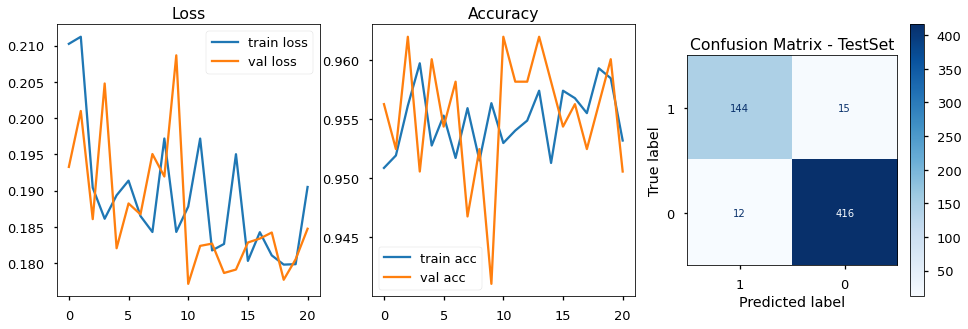

In [200]:
visualize_model_performance(Increased_Batch_CNN, train_image, test_image, "acc", "val_acc")

## CNN with decreased batch size:

There is a high correlation between the learning rate and the batch size, when the learning rates are high, the large batch size performs better than with small learning rates. We recommend choosing small batch size with low learning rate.

One of the key hyperparameters to set in order to train a neural network is the learning rate for gradient descent. As a reminder, this parameter scales the magnitude of our weight updates in order to minimize the network's loss function.

If your learning rate is set too low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function. 

In [218]:
optm = optimizers.Adam(learning_rate=0.0001)  #beta_1=0.9, beta_2=0.999, amsgrad=False
 
model.compile(optimizer = optm, loss = 'binary_crossentropy', metrics = ['acc'])


Decreased_Batch_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=17,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
279/279 [==============================] - 47s 168ms/step - loss: 0.3760 - acc: 0.9129 - val_loss: 0.3519 - val_acc: 0.9221
Epoch 2/100
279/279 [==============================] - 52s 187ms/step - loss: 0.3410 - acc: 0.9203 - val_loss: 0.3360 - val_acc: 0.9202
Epoch 3/100
279/279 [==============================] - 58s 210ms/step - loss: 0.3279 - acc: 0.9169 - val_loss: 0.3051 - val_acc: 0.9354
Epoch 4/100
279/279 [==============================] - 54s 194ms/step - loss: 0.3165 - acc: 0.9203 - val_loss: 0.3035 - val_acc: 0.9278
Epoch 5/100
279/279 [==============================] - 55s 195ms/step - loss: 0.2969 - acc: 0.9262 - val_loss: 0.2899 - val_acc: 0.9354
Epoch 6/100
279/279 [==============================] - 58s 208ms/step - loss: 0.2944 - acc: 0.9273 - val_loss: 0.2851 - val_acc: 0.9335
Epoch 7/100
279/279 [==============================] - 55s 196ms/step - loss: 0.2834 - acc: 0.9300 - val_loss: 0.2688 - val_acc: 0.9411
Epoch 8/100
279/279 [===========================

KeyboardInterrupt: 

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       159
           1       0.97      0.96      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 59ms/step - loss: 0.1927 - acc: 0.9506
--------------------------
Final Train Loss: 0.1675
Final Test Loss: 0.1927
--------------------------
Final Train Acc: 0.9665
Final Test Acc: 0.9506




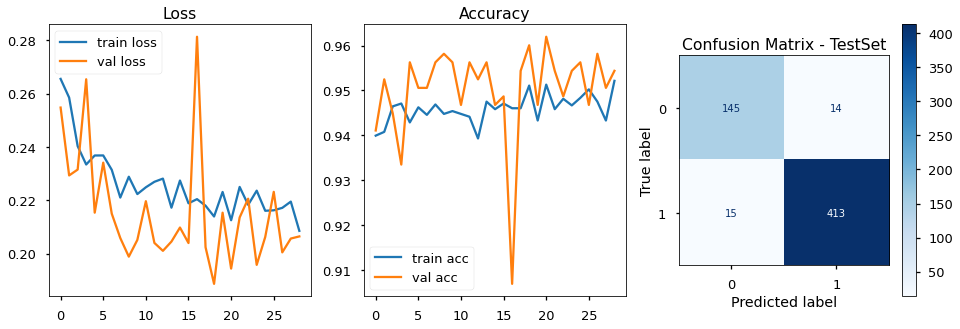

In [214]:
visualize_model_performance(Decreased_Batch_CNN, train_image, test_image, "acc", "val_acc")

### Load an Image

In [249]:
import Image

def is_grey_scale('Data/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg'):
    img = Image.open('Data/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg').convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

SyntaxError: invalid syntax (<ipython-input-249-c3c0b87b05fc>, line 3)

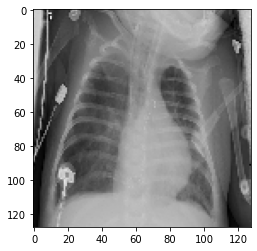

In [254]:
filename = 'Data/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg'
img = image.load_img(filename, target_size=(128, 128))
plt.imshow(img)
plt.show()

### Transform the Image to a Tensor and Visualize Again

(1, 128, 128, 3)


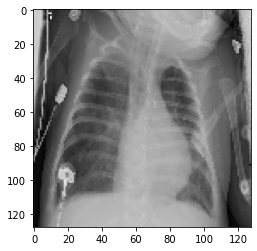

In [255]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Follow the Original Model Preprocessing
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview an image
plt.imshow(img_tensor[0])
plt.show()

### Plot Feature Maps

In [256]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [257]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 128)     

From this, you can see that the initial two layers output feature maps that have 32 channels each. You can visualize each of these channels individually by slicing the tensor along that axis. Subsequentially, the next two layers have 64 channels each and the 5th through 8th layers have 128 channels each. Recall that this allows the CNN to detect successively more abstract patterns. Here's what slicing one of these feature maps and visualizing an individual channel looks like in practice:


More extensively, we could also visualize all 32 of these channels from the first activation function.


In [258]:
activations = activation_model.predict(img_tensor)

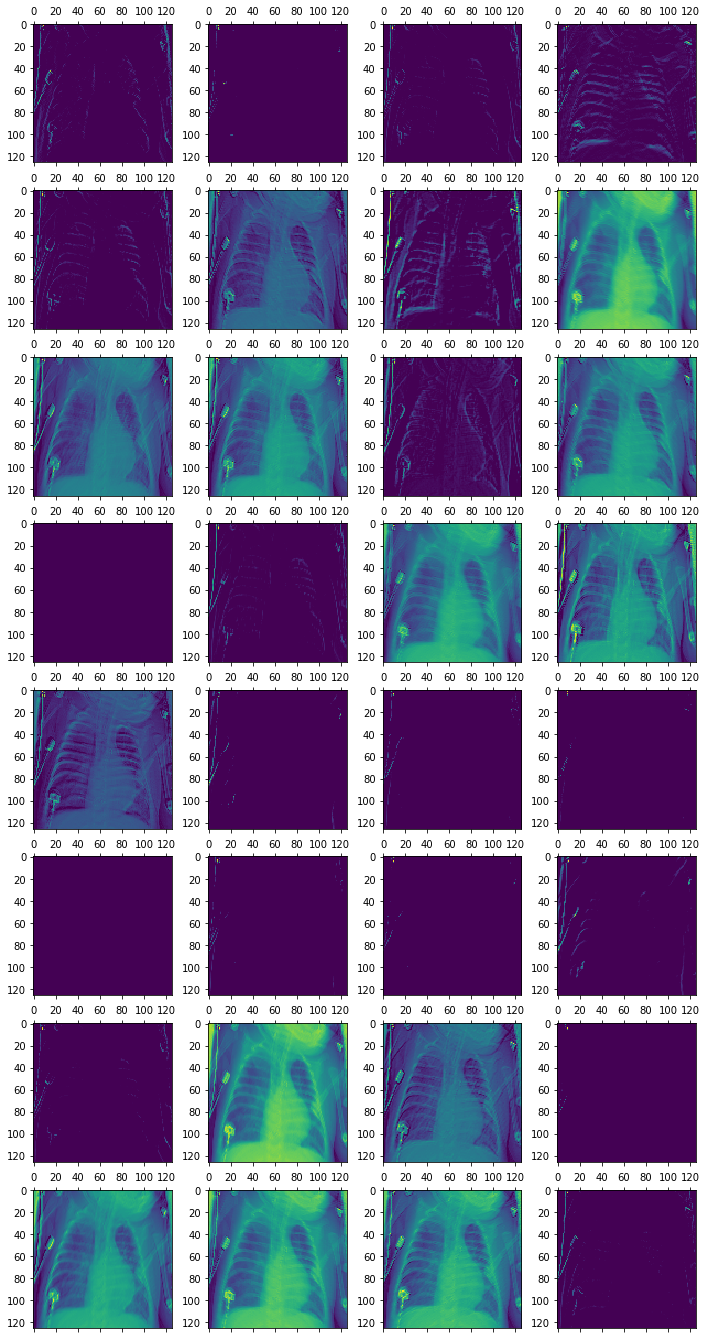

In [259]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

## Repeating for all Layers:

Similarly, you could also visualize other layers. Below is the visualization of the 29th channel for each of the activation layers. (Recall that there are more channels in later layers.)

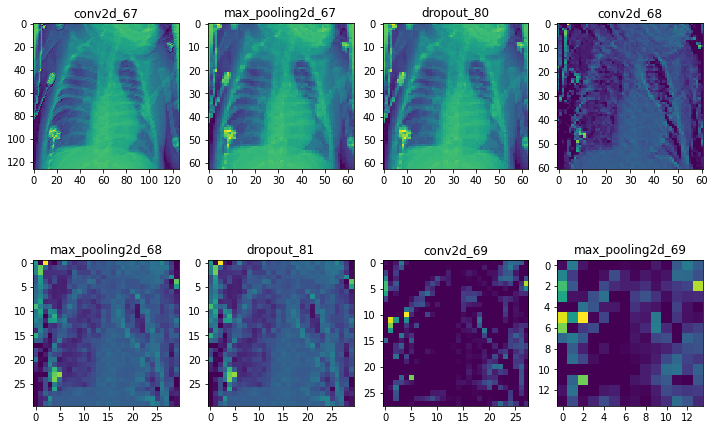

In [265]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 30], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

Note how the later layers are more abstract representations, and in the case of the final two layers, we see nothing at all. This demonstrates how the representations learned by CNN architectures become increasingly abstract with the depth of the layers. In the case of the blank images displayed, this indicates that the patterns were not present in the current image.

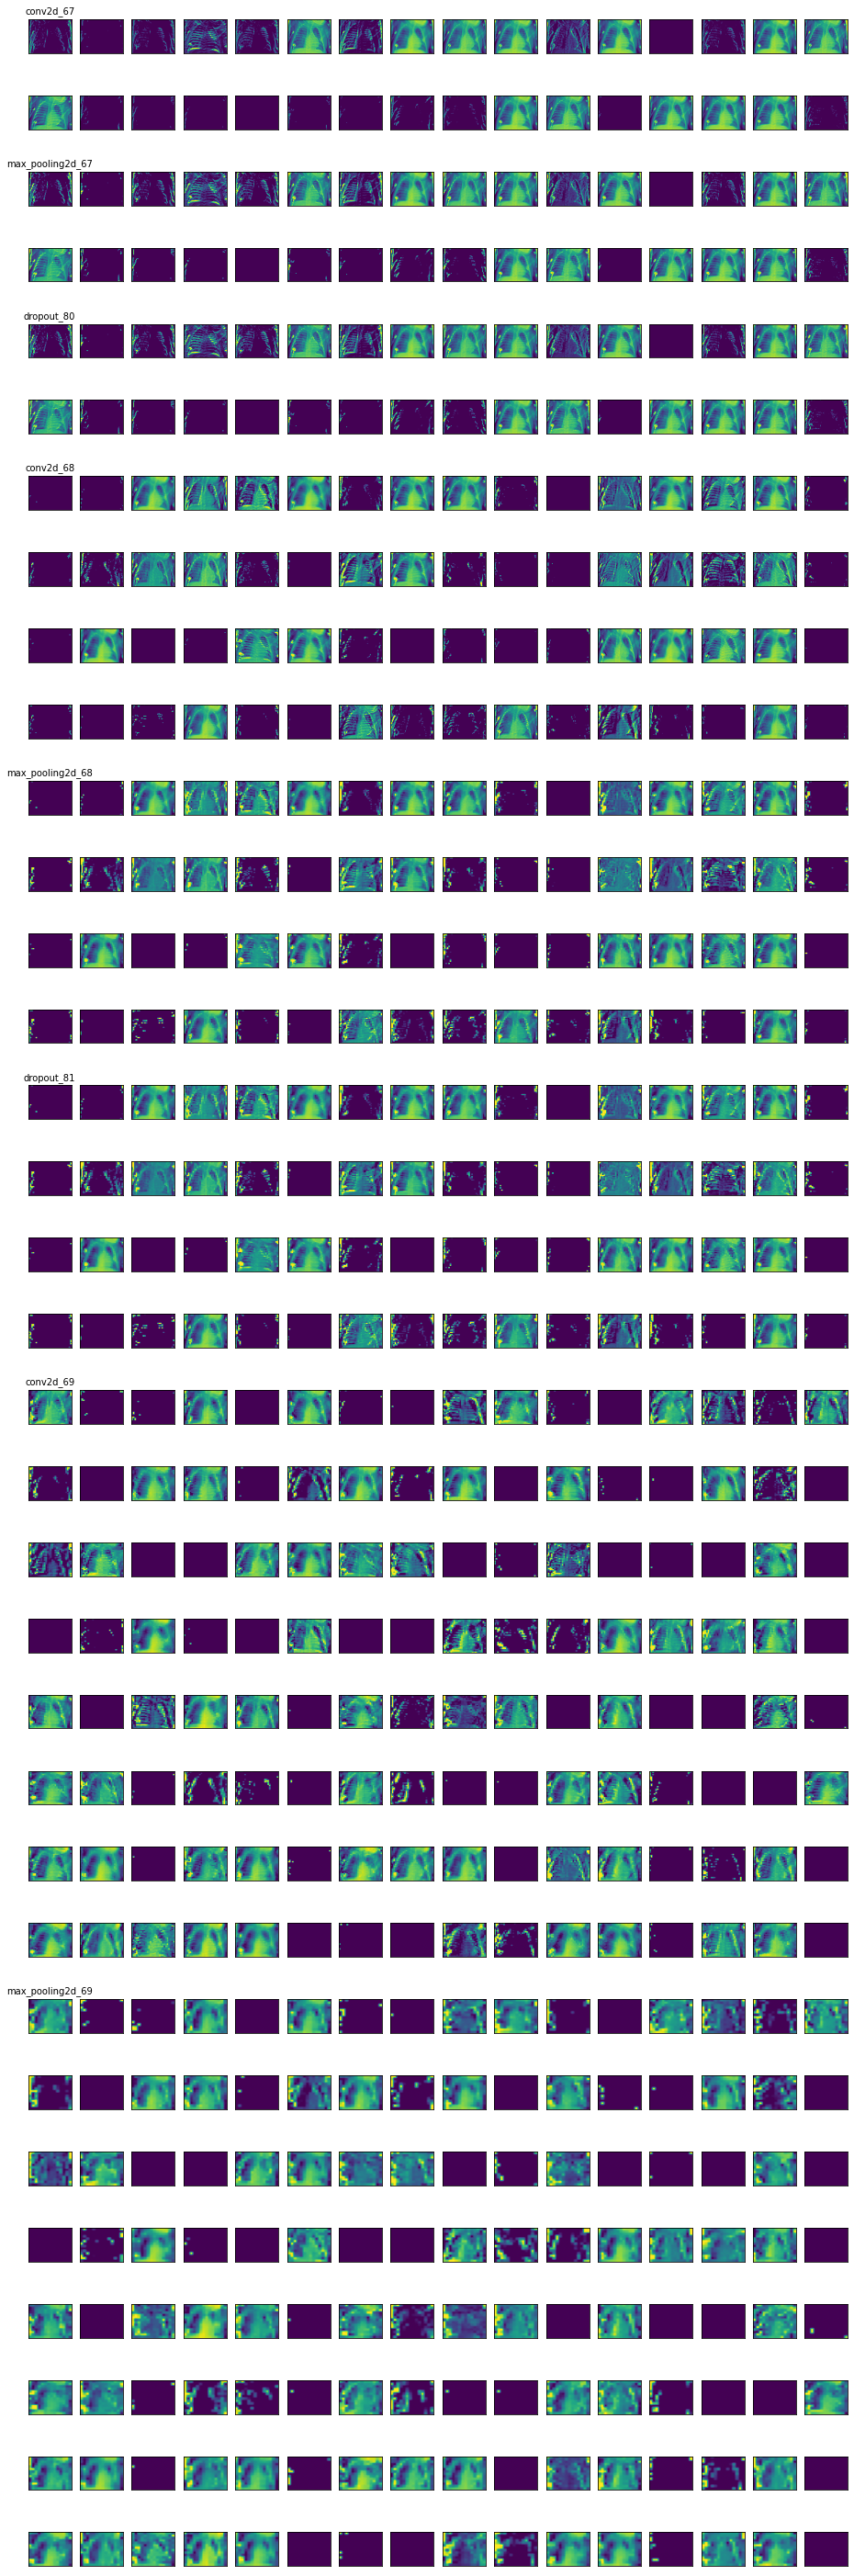

In [266]:
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, 10000,
                                        0.95, staircase=True)
opt = tf.train.AdamOptimizer(decayed_lr, epsilon=adam_epsilon)


In [ ]:
decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, 10000,
                                        0.95, staircase=True)
opt = tf.train.AdamOptimizer(decayed_lr, epsilon=adam_epsilon)

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
from keras.models import load_model
saved_model = load_model('best_model.h5')
saved_model

saved_model.evaluate(train_image, test_image, verbose=0)
saved_model.evaluate(train_image, test_image, verbose=0)

In [ ]:
from keras.models import load_model
saved_model = load_model('best_model.h5')
BiggerCNN = saved_model.evaluate(train_image, y_train)

In [ ]:
# use the hyperparameters that achieve the highest performance

learning_rate = 0.001
droprate = 0.8
size = 100


    model.add(layers.Dropout(droprate)) # regularization
    

    
    
    # optimization parameters
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    loss='binary_crossentropy'
    model.compile(loss=loss,
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

In [ ]:
!pip install h5py

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Architechture of the CNN
# Set up early stopping and learning rate reduction
# Patience= Number of epochs with no improvement after which training will be stopped.

# ModelCheckpoint callback is used in conjunction with training using model.fit() 
# to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

# checkpoint_filepath = '/tmp/checkpoint'

# Define stopping criterion
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stop, model_checkpoint]

# Look at the FINAL Model Explanation
Look at the features of the image that are contributing to its class prediction

How to Visualize Filters and Feature Maps in Convolutional Neural Networks

In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

Because each method adapts the learning rate, often one learning rate per model weight, little configuration is often required.Three commonly used adaptive learning rate methods include:
- RMSProp 
- Adagrad
- Adam

## Updated Model

Address the class imbalance using class weights
based on the results of the baseline model's confusion matrix, which shows the model is predicting mostly one class

Experiment with more epochs and early stopping
might prevent overfitting

Reduce batch size
might improve accuracy


Going off of iteration 2, I will try to rework the validation set size to see if it makes any improvements in the loss and accuracy curves.
results = mod3.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=30,
                   validation_split=.2,
                   class_weight=weights_dict,
                   callbacks=callbacks)
                   
                   
In this iteration, I will deepen the neural network to include more layers to hopefully pull more features out of the images to improve the model
     

In [ ]:
# Define stopping criterion
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stop]

In [ ]:
# Set random seed for reproducability

SEED = 123456
import os
import random as rn
import numpy as np
import tensorflow


tensorflow.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
python_random.seed(SEED)


## Recommendations

* Target physicians by educating them on the importance of vaccination &  recommending it to their patients!
* Target uninsured populations in the campaign, but better yet work on universal health coverage for all individuals and communities.
* Focus your campaign on informing the people about the effectiveness and safety of the vaccine or their risk of falling ill and developing complications if not vaccinated. 
* As a priority keep focusing your campaign on older age groups, because they are at more risk of developing flu-related complications compared to younger age groups. But also target younger people as a key demographic population since their vaccination rates are much lower.


## Next Steps

* Encrypted employment industry, employment occupation, and geographical region info, hard to make any specific suggestions based on these features. 
* Results on health insurance are not very reliable due to 40% of the data being null and being encoded using predictive modeling. More care needs to be given to this variable next time the survey is conducted since it is a significant feature in predicting vaccine outcome. 
* More recent data needs to be collected after the Covid-19 pandemic since the pandemic might have altered people’s attitude towards flu vaccine as well. 

**Exporting to PDF using nbconvert**:
1. install nbconvert: ! pip install nbconvert
2. install MacTeX from tps://tug.org/mactex/
3. ! export PATH=/Library/TeX/texbin:$PATH
4. ! jupyter nbconvert --to PDF NOTEBOOKNAME.ipynb